### 1.Import das Bibliotecas

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
warnings.filterwarnings('ignore')

In [ ]:
base_path = r"C:\Users\bruno\OneDrive\Desktop\Modelos\Classification"
file_path = f"{base_path}\\dataset\\heart_failure_clinical_records_dataset.csv"

In [17]:
df = pd.read_csv(file_path)
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


#### 2. Dicionário de Dados

- **`age`**: Idade do paciente em anos.
- **`anaemia`**: Indica se o paciente tem anemia (0 = Não, 1 = Sim).
- **`creatinine_phosphokinase`**: Nível de creatinina fosfoquinase no sangue (mcg/L).
- **`diabetes`**: Indica se o paciente tem diabetes (0 = Não, 1 = Sim).
- **`ejection_fraction`**: Porcentagem de sangue saindo do coração a cada contração (%).
- **`high_blood_pressure`**: Indica se o paciente tem hipertensão (0 = Não, 1 = Sim).
- **`platelets`**: Contagem de plaquetas no sangue (quilhões/L).
- **`serum_creatinine`**: Nível de creatinina sérica no sangue (mg/dL).
- **`serum_sodium`**: Nível de sódio sérico no sangue (mEq/L).
- **`sex`**: Sexo do paciente (0 = Feminino, 1 = Masculino).
- **`smoking`**: Indica se o paciente é fumante (0 = Não, 1 = Sim).
- **`time`**: Tempo de acompanhamento em dias.
- **`DEATH_EVENT`**: Variável Alvo - Indica se houve óbito durante o acompanhamento (0 = Não, 1 = Sim).

In [18]:
df.shape

(299, 13)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


### 2. Data Splitting

In [22]:
X = df.drop(columns=['DEATH_EVENT'])  # Variáveis independentes
y = df['DEATH_EVENT']  # Variável dependente

# Divisão dos dados: 80% treino, 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Exibe as dimensões dos dados divididos
print("Treinamento:", X_train.shape, y_train.shape)
print("Teste:", X_test.shape, y_test.shape)

Treinamento: (239, 12) (239,)
Teste: (60, 12) (60,)


#### 3. Análise das Variáveis Numéricas

In [23]:
# Combine os dados de treino
train_data = pd.concat([X_train, y_train], axis=1)

# Visualize os primeiros registros
print(train_data.head())

        age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
6    75.000        1                       246         0                 15   
183  75.000        0                        99         0                 38   
185  60.667        1                       104         1                 30   
146  52.000        0                       132         0                 30   
30   94.000        0                       582         1                 38   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
6                      0  127000.00              1.20           137    1   
183                    1  224000.00              2.50           134    1   
185                    0  389000.00              1.50           136    1   
146                    0  218000.00              0.70           136    1   
30                     1  263358.03              1.83           134    1   

     smoking  time  DEATH_EVENT  
6          0    10            1  


#### 3.1 Análise das Distribuições

In [31]:
# Resumo estatístico das variáveis
distribution = ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time']
flags = ['anaemia','diabetes','high_blood_pressure','sex','smoking','DEATH_EVENT']

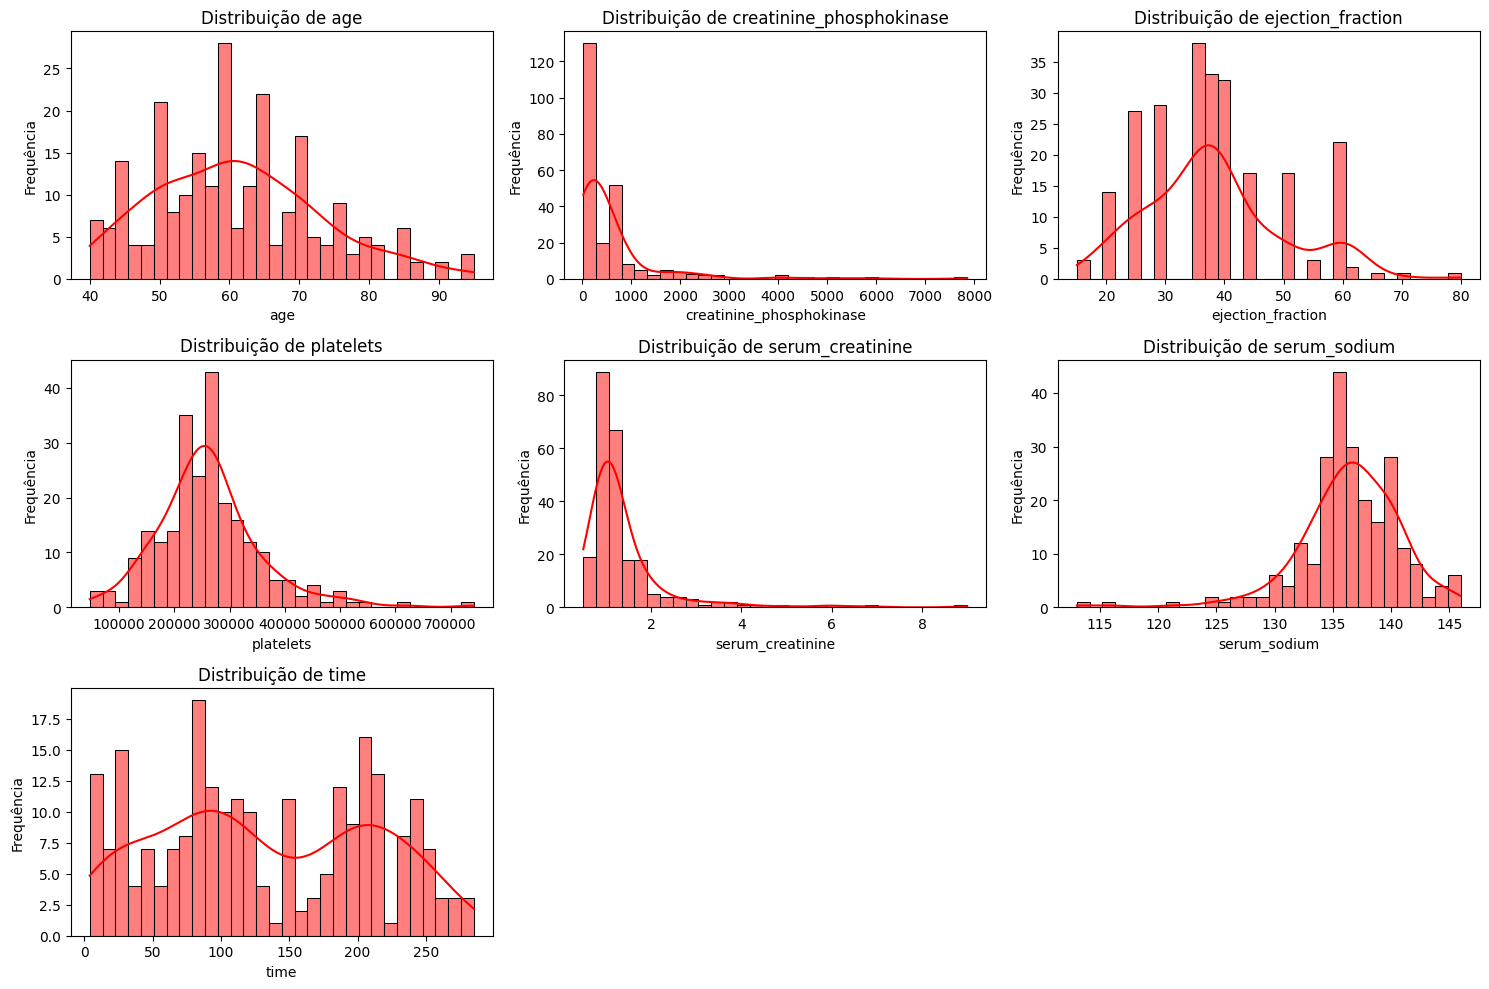

In [29]:
# Definir o tamanho da figura
plt.figure(figsize=(15, 10))

# Criar um subplot para cada variável
for i, var in enumerate(distribution, 1):
    plt.subplot(3, 3, i)  # Organizar os gráficos em 3x3 (ajustar conforme necessário)
    sns.histplot(train_data[var], kde=True, bins=30, color='red', edgecolor='black')  # Histograma com KDE
    plt.title(f'Distribuição de {var}')
    plt.xlabel(var)
    plt.ylabel('Frequência')

# Ajustar o layout para não sobrepor os gráficos
plt.tight_layout()
plt.show()


###### A única variável que não é contínua nesse conjunto é ejection_fraction, e ele será utilizada de maneira diferente nos processos a seguir.

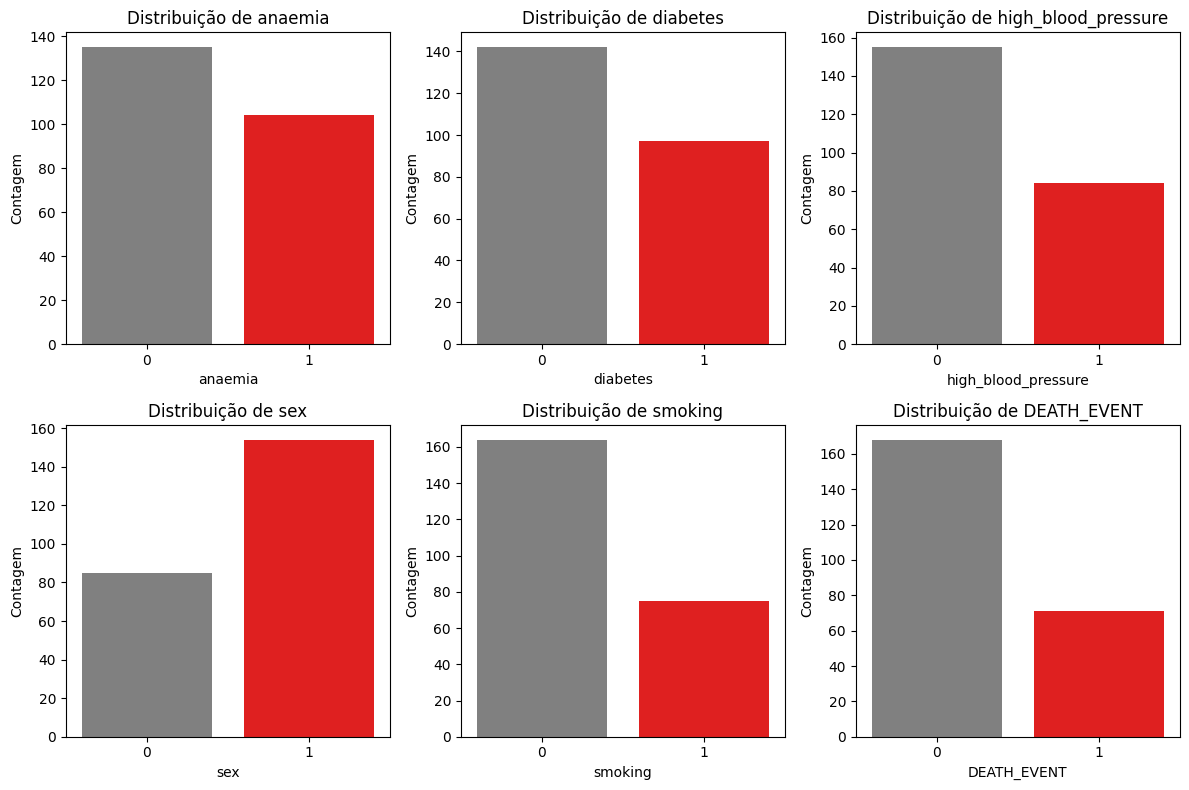

In [38]:
# Definir o tamanho da figura
plt.figure(figsize=(12, 8))

# Criar um subplot para cada variável binária
for i, var in enumerate(flags, 1):
    plt.subplot(2, 3, i)  # Organizar os gráficos em 2x3 (ajustar conforme necessário)
    
    # Customizando as cores para 0 (cinza) e 1 (vermelho)
    sns.countplot(data=train_data, x=var, palette={'0': 'gray', '1': 'red'})
    
    plt.title(f'Distribuição de {var}')
    plt.xlabel(var)
    plt.ylabel('Contagem')

# Ajustar o layout para não sobrepor os gráficos
plt.tight_layout()
plt.show()


##### 3.2 Correlação de Pearson

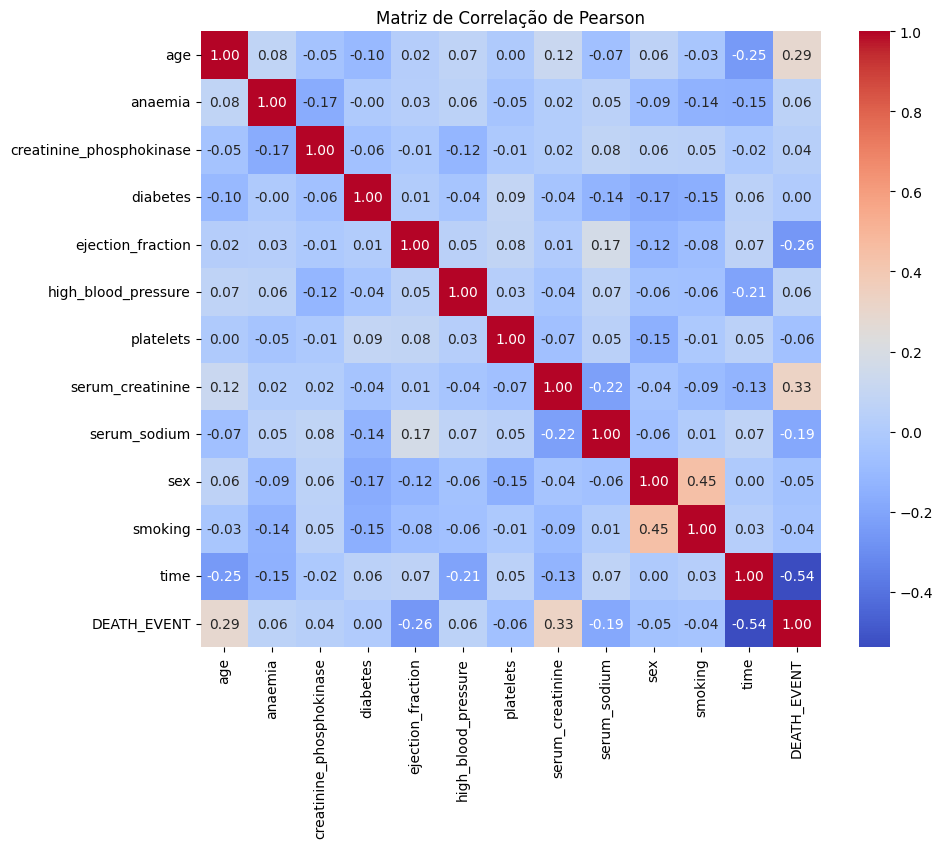

In [39]:
# Calcular a correlação de Pearson
correlation_matrix = train_data.corr(method='pearson')

# Visualizar a matriz de correlação com um heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Matriz de Correlação de Pearson')
plt.show()


###### Não possuem variáveis com alta correlação com o target **`DEATH_EVENT`**, vamos investir na criação de features automáticas para encontrar variáveis mais correlacionadas.

#### 4. Feature Enginnering

###### Nessa etapa vamos explorar a utilização da biblioteca Feature-Engine para a criação de features automáticas com o objetivo de otimizar ainda mais as variáveis no dataset

###### A Feature-engine é uma biblioteca Python projetada para facilitar o processo de engenharia de features em datasets tabulares, com foco em pré-processamento, transformação e criação de novas features. Ela fornece uma série de ferramentas para melhorar a qualidade e a performance do modelo de machine learning por meio da manipulação das variáveis.

In [46]:
continuas  = ['age','creatinine_phosphokinase','platelets','serum_creatinine','serum_sodium','time']

n_continuas = ['ejection_fraction']

flags_st = ['anaemia','diabetes','high_blood_pressure','sex','smoking']


##### 4.1 Criação de Variáveis Quadráticas

In [69]:
# Calculando o quadrado das variáveis contínuas
train_data_square = train_data[continuas] ** 2

# Renomeando as colunas para indicar que são variáveis ao quadrado
train_data_square.columns = [f'{col}_square' for col in continuas]

# Concatenando as variáveis transformadas ao DataFrame original
train_data_square = pd.concat([train_data, train_data_square], axis=1)

# Exibindo as primeiras linhas do conjunto de dados transformado
train_data_square.head()


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,age_square,creatinine_phosphokinase_square,platelets_square,serum_creatinine_square,serum_sodium_square,time_square
6,75.000,1,246,0,15,0,127000.00,1.20,137,1,0,10,1,5625.000000,60516,1.612900e+10,1.4400,18769,100
183,75.000,0,99,0,38,1,224000.00,2.50,134,1,0,162,1,5625.000000,9801,5.017600e+10,6.2500,17956,26244
185,60.667,1,104,1,30,0,389000.00,1.50,136,1,0,171,1,3680.484889,10816,1.513210e+11,2.2500,18496,29241
146,52.000,0,132,0,30,0,218000.00,0.70,136,1,1,112,0,2704.000000,17424,4.752400e+10,0.4900,18496,12544
30,94.000,0,582,1,38,1,263358.03,1.83,134,1,0,27,1,8836.000000,338724,6.935745e+10,3.3489,17956,729


##### 4.2 Criação de Variáveis Logarítmicas

In [71]:
# Aplicando a transformação logarítmica e criando novas variáveis
train_data_log = np.log(train_data[continuas])

# Renomeando as colunas para refletir que são logarítmicas
train_data_log.columns = [f'{col}_log' for col in train_data_log.columns]

# Concatenando as variáveis logarítmicas com o dataset original
train_data_log = pd.concat([train_data_square, train_data_log], axis=1)

# Exibindo as primeiras linhas para verificar
train_data_log.head()


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,...,platelets_square,serum_creatinine_square,serum_sodium_square,time_square,age_log,creatinine_phosphokinase_log,platelets_log,serum_creatinine_log,serum_sodium_log,time_log
6,75.000,1,246,0,15,0,127000.00,1.20,137,1,...,1.612900e+10,1.4400,18769,100,4.317488,5.505332,11.751942,0.182322,4.919981,2.302585
183,75.000,0,99,0,38,1,224000.00,2.50,134,1,...,5.017600e+10,6.2500,17956,26244,4.317488,4.595120,12.319401,0.916291,4.897840,5.087596
185,60.667,1,104,1,30,0,389000.00,1.50,136,1,...,1.513210e+11,2.2500,18496,29241,4.105400,4.644391,12.871335,0.405465,4.912655,5.141664
146,52.000,0,132,0,30,0,218000.00,0.70,136,1,...,4.752400e+10,0.4900,18496,12544,3.951244,4.882802,12.292250,-0.356675,4.912655,4.718499
30,94.000,0,582,1,38,1,263358.03,1.83,134,1,...,6.935745e+10,3.3489,17956,729,4.543295,6.366470,12.481270,0.604316,4.897840,3.295837


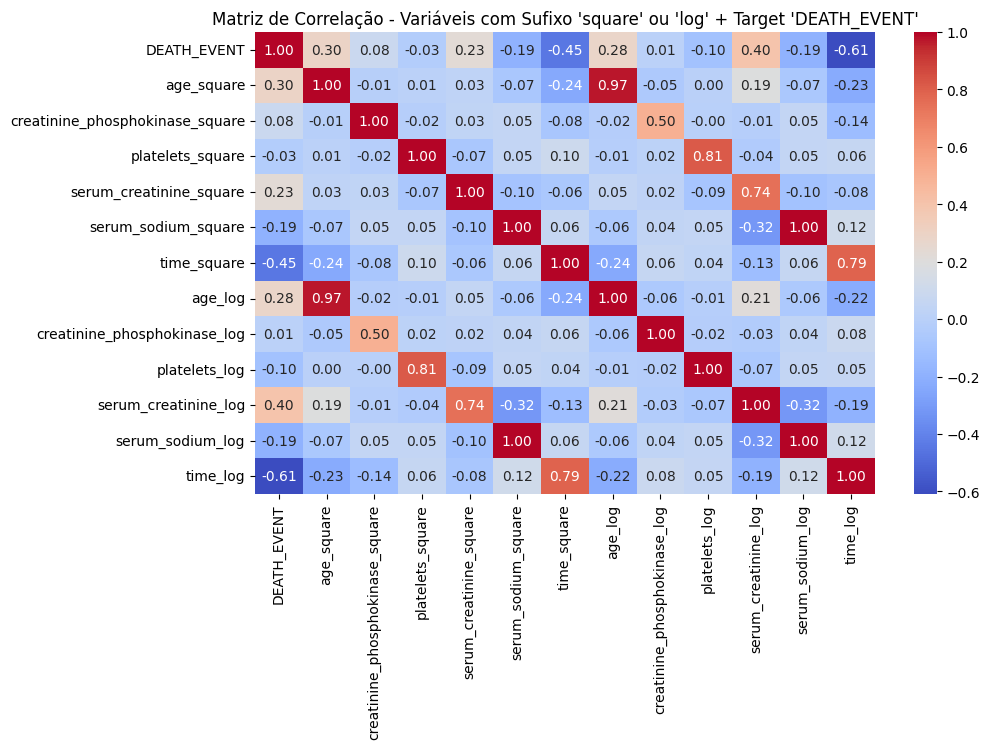

In [73]:
# Filtrando as variáveis com sufixo 'square' ou 'log' e incluindo o target 'DEATH_EVENT'
columns_to_analyze = [col for col in train_data_log.columns if ('square' in col or 'log' in col) or col == 'DEATH_EVENT']

# Criando a sub-matriz de correlação para essas variáveis
correlation_matrix_log_filtered = train_data_log[columns_to_analyze].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_log_filtered, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação - Variáveis com Sufixo 'square' ou 'log' + Target 'DEATH_EVENT'")
plt.show()

